# Energy Expenditure

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import copy
import seaborn as sns
import pickle

import Tracab as tracab
import Tracking_Visuals as vis
import Tracking_Velocities as vel
import helpers
import scipy.signal as signal
import scipy

import importlib
importlib.reload(tracab)
importlib.reload(helpers)
importlib.reload(vis)

<module 'Tracking_Visuals' from '/Users/jeffbalkanski/research_soccer/SoccerTrackingData3/Tracking_Visuals.py'>

In [3]:
# config
current_dir = os.path.dirname(os.getcwd())
fpath = os.path.join(current_dir, 'TrackingSample') # path to directory of Tracab data
LEAGUE = 'DSL'

## Data

In [3]:
# read frames, match meta data, and data for individual players
fname = '984628'
frames_tb, match_tb, team1_players, team0_players = tracab.read_tracab_match_data(
    LEAGUE, fpath, fname, verbose=True)

Reading match metadata
Reading match tracking data
Timestamping frames
Measuring velocities
home goalkeeper(s):  [1]
away goalkeeper(s):  [73]
0 67615
67616 139808


### Pickle objects

In [4]:
# save
for obj, filename in zip([frames_tb, match_tb, team1_players, team0_players], ['frames', 'match', 'team1', 'team0']):
    with open(os.path.join('./saved', filename),'wb') as outfile:
        pickle.dump(obj, outfile)

In [5]:
# read
# for obj, filename in zip([frames_tb, match_tb, team1_players, team0_players], ['frames', 'match', 'team1', 'team0']):

with open(os.path.join('./saved', 'team1'),'rb') as infile:
    team1_players = pickle.load(infile)
    print('Done reading pickle objet team1')
    
with open(os.path.join('./saved', 'team0'),'rb') as infile:
    team0_players = pickle.load(infile)
    print('Done reading pickle objet team0')

Done reading pickle objet team1
Done reading pickle objet team0


### Visualize

In [95]:
# pick a player
player = team1_players[32]

In [96]:
# metrics available
target_ex = player.frame_targets[100]
vars(target_ex)

{'team': 1,
 'sys_target_ID': 20,
 'jersey_num': 32,
 'pos_x': 2051.0,
 'pos_y': -597.0,
 'speed': 1.12,
 'timestamp': 4.0,
 'vx': -0.25,
 'vy': 1.321,
 'v_filter': 1.344,
 'ax': -1.786,
 'ay': 0.957,
 'a_filter': 2.026,
 'VeBDA': 152.48300000000003}

# Acceleration

In [97]:
# get values
velocities = helpers.get_all_values(player, 'v_filter')
axs = helpers.get_all_values(player, 'ax', start=10, skip_last=10)
accelerations = helpers.get_all_values(player, 'a_filter', start=10, skip_last=10)

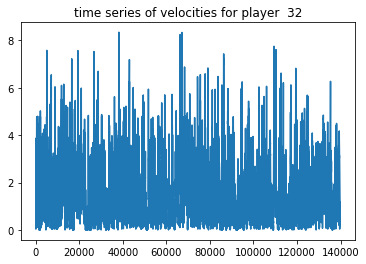

In [98]:
# velocities
plt.plot(velocities)
plt.title('time series of velocities for player  {}'.format(player.jersey_num))
plt.show()

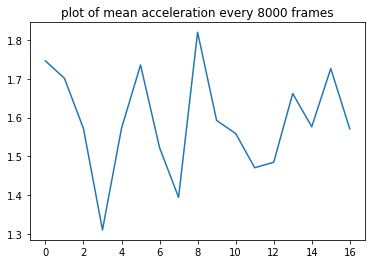

In [99]:
# plot every 
k = 8000
mean_every_k = helpers.get_mean_every_k(accelerations, k=k)
plt.plot(mean_every_k)
plt.title('plot of mean acceleration every {} frames'.format(k))
plt.show()

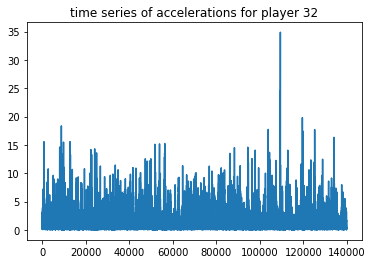

In [100]:
# accelerations
plt.plot(accelerations)
plt.title('time series of accelerations for player {}'.format(player.jersey_num))
plt.show()

# Energy expenditure calculation

We want to make make time series of energy expenditure for each player

1. **VeBVD =** sum of acceleration vectors
2. **metabolic power**  = 5th degree polynomial
3. product 

In [101]:
import Tracking_Fatigue as fatigue
importlib.reload(fatigue)


<module 'Tracking_Fatigue' from '/Users/jeffbalkanski/research_soccer/SoccerTrackingData3/Tracking_Fatigue.py'>

In [102]:
all_players = list(team0_players.items()) + list(team1_players.items())


In [103]:
# ts = helpers.get_all_values(player, 'timestamp')

## Cumulative distance

In [104]:
cumul_d = fatigue.get_cumulative_distance(player)

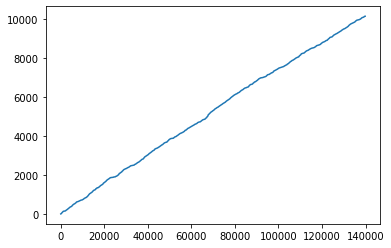

In [105]:
plt.plot(cumul_d)
plt.show()

## VeBDA - Vector Dynamic Body Acceleration,
the VeDBA at time t, is `a_magnitude`. there is no a_magnitude on first frame!

For a possession starting at $s_n$ and ending at $e_n$ , the VeBDA for that posession is 
$$V'_n = \sum_{t=s_n}^{e_n}V_t$$

In [108]:
# compute
fatigue.estimate_player_VeBDA(team1_players, team0_players)


In [ ]:
# ts = helpers.get_all_values(player, 'timestamp', start=1)

In [ ]:
for team, player in all_players:
    plt.clf()
    
    vebda_toplot = helpers.get_all_values(player, 'VeBDA', start=1)
    plt.plot(vebda_toplot)
    plt.title('Plot of VeBDA for player {} of team {}'.format(player.jersey_num, player.teamID))
    plt.savefig('./figures/VeBDA/time_series_all_{}_player_{}.jpg'.format(player.teamID, player.jersey_num))

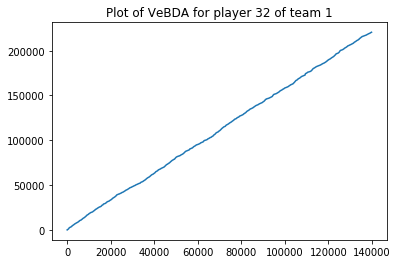

In [109]:
vebda_toplot = helpers.get_all_values(player, 'VeBDA', start=1)
plt.plot(vebda_toplot)
plt.title('Plot of VeBDA for player {} of team {}'.format(player.jersey_num, player.teamID))
plt.show()

## Metabolic power
First must find the **energy cost**
$$EC =155.4i^5 −30.4i^4 −43.3i^3 +46.3i^2 +19.5i +3.6$$

In [115]:
# get accelerations
ax = helpers.get_all_values(player, 'ax', start=1)
ay = helpers.get_all_values(player, 'ay', start=1)
vx = helpers.get_all_values(player, 'vx', start=1)
vy = helpers.get_all_values(player, 'vy', start=1)

# in m/s^2
g = 9.81

g/ax

/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


array([306.5625    , 306.5625    , 306.5625    , ...,  -6.27639155,
        -6.27639155,  -6.27639155])

In [24]:
def estimate_metabolic_power(team1_players, team0_players):
    # get for all players
    all_players = list(team0_players.items()) + list(team1_players.items())
    for (num, player) in all_players:
        
        # get accelerations
        ax = helpers.get_all_values(player, 'ax', start=1)
        ay = helpers.get_all_values(player, 'ay', start=1)
        vx = helpers.get_all_values(player, 'vx', start=1)
        vy = helpers.get_all_values(player, 'vy', start=1)

        # in m/s^2
        g = 9.81

        # find angle, of equivalent slope
        ix = np.tan(np.pi/2. - np.arctan(g/ax))
        iy = np.tan(np.pi/2. - np.arctan(g/ay)) 

        # find energy cost
        EC_x = 155.4*ix**5 - 30.4*ix**4 - 43.3*ix**3 + 46.3*ix**2 + 19.5*ix + 3.6
        EC_y = 155.4*iy**5 - 30.4*iy**4 - 43.3*iy**3 + 46.3*iy**2 + 19.5*iy + 3.6

        # equivalent mass ratio
        mx = np.sqrt((np.power(ax, 2)/g**2) + 1)
        my = np.sqrt((np.power(ay, 2)/g**2) + 1)

        # matabolic power
        Px = np.multiply(EC_x, mx, vx)
        Py = np.multiply(EC_y, my, vy)

        metabolic_power = Px + Py

        # store
        for i, frame in enumerate(player.frame_targets[1:]):
            frame.metabolic = metabolic_power[i]

        break

In [25]:
# compute for all players
estimate_metabolic_power(team1_players, team0_players)

/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in arctan
  app.launch_new_instance()
/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in arctan


In [179]:
ax = helpers.get_all_values(player, 'ax', start=1)
ay = helpers.get_all_values(player, 'ay', start=1)

# problem
print('there are many null values of accelerations')
print(np.where(ax == 0)[0].shape, np.where(ay == 0)[0].shape)

there are many null values of accelerations
(31302,) (31253,)


In [149]:
metabolic_lst = helpers.get_all_values(player, 'metabolic', start=1)

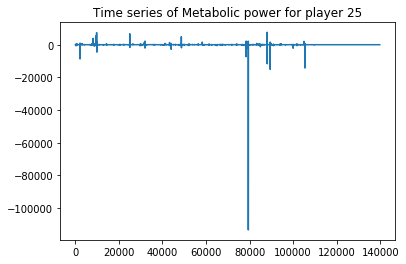

In [152]:
# plot 
plt.plot(metabolic_lst)
plt.title('Time series of Metabolic power for player {}'.format(player.jersey_num))
plt.show()

## Energy expenditure (Laurie)
- Ar = 0.45 m2 which is surface of a person
- ro = 1.225 kgm-3 is resitance of air
- m is 65 kg
- C_d is 0.85
- Beta = Ar * ro/ 2

Next steps:
> Make the model better by adapting `m` and `Ar` to each player

In [116]:
print(player.jersey_num, player.teamID)

32 1


In [110]:
Ar = 0.45
ro = 1.225 # resistance of air
m = 65
C_d = 0.85
Beta = Ar * ro/ 2
energy_constants = {'Ar': Ar, 'ro': ro, 'm': m, 'C_d': C_d, 'Beta': Beta}

In [189]:
def energy_expenditure(player, c=energy_constants, wind_resistance=True):  
    # no acceleration on 1st frame > compute everything for only after 1st frame
    v = helpers.get_all_values(player, 'v_filter', start=1)
    a = helpers.get_all_values(player, 'a_filter', start=1)
    n_frames = len(v)
    W = np.zeros(n_frames)
    dt = np.diff([player.frame_timestamps[i] * 60 for i in range(len(player.frame_targets))])

    # get rid of mid time
    midtime_index = np.where(dt < -1)
    v, a, dt = [np.delete(arr, midtime_index) for arr in [v, a, dt]]

    # energy expenditure
    F = m * a
    wind = (Beta * v**2)/2 if wind_resistance else 0
    E_expend = (F + wind) * np.multiply(v, dt)
    
    return E_expend


# def add_to_player(team1_players, team0_players, func, metric_name):
    all_players = list(team0_players.items()) + list(team1_players.items())
    for (num, player) in all_players:
        metric = func(player)
        
        # store info
        for i, frame in enumerate(player.frame_targets[1:]):
            frame.metric_name = metric[i]

In [201]:
all_players = list(team0_players.items()) + list(team1_players.items())
for (num, player) in all_players:
    metric = energy_expenditure(player)

    # store info
    for i, frame in enumerate(player.frame_targets[1:-1]):
        frame.metric_name = metric[i]

In [186]:
# compute
E_expend = energy_expenditure(player)

32 <Tracab.tracab_player object at 0x1c1aa0f2d0>
1 <Tracab.tracab_player object at 0x1c369d3850>
2 <Tracab.tracab_player object at 0x1c612f96d0>
5 <Tracab.tracab_player object at 0x1c92b16a50>
7 <Tracab.tracab_player object at 0x1cb5686dd0>
8 <Tracab.tracab_player object at 0x1c6f38d190>
9 <Tracab.tracab_player object at 0x1c48a48510>
10 <Tracab.tracab_player object at 0x1c7e9e9890>
11 <Tracab.tracab_player object at 0x1cdbb28c10>
17 <Tracab.tracab_player object at 0x1ce2260f90>
18 <Tracab.tracab_player object at 0x1ce899a350>
21 <Tracab.tracab_player object at 0x1cef0d26d0>
25 <Tracab.tracab_player object at 0x1cf8ec0a50>


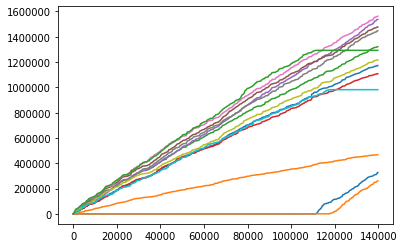

In [212]:
for i, player in team1_players.items():
    print(i, player)
    E_expend = energy_expenditure(player)
    cumul_E = np.cumsum(E_expend)
    plt.plot(cumul_E)
    
plt.show()

32 <Tracab.tracab_player object at 0x1c1aa0f2d0>


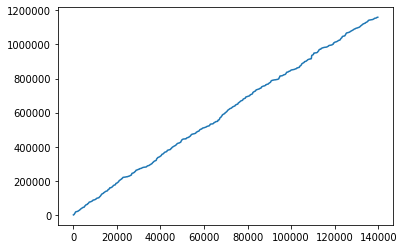

1 <Tracab.tracab_player object at 0x1c369d3850>


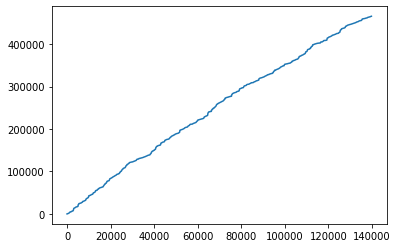

2 <Tracab.tracab_player object at 0x1c612f96d0>


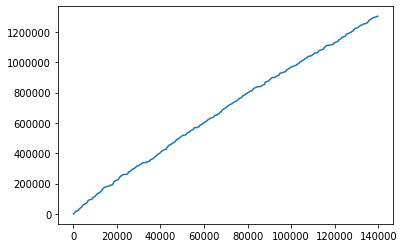

5 <Tracab.tracab_player object at 0x1c92b16a50>


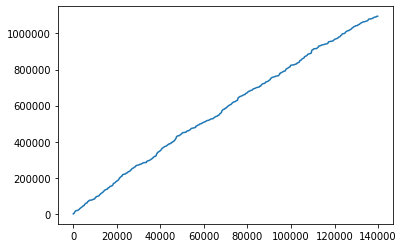

7 <Tracab.tracab_player object at 0x1cb5686dd0>


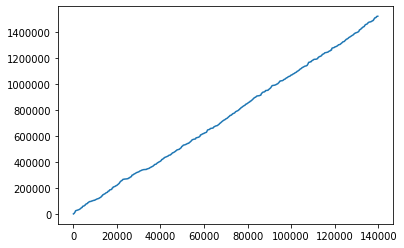

8 <Tracab.tracab_player object at 0x1c6f38d190>


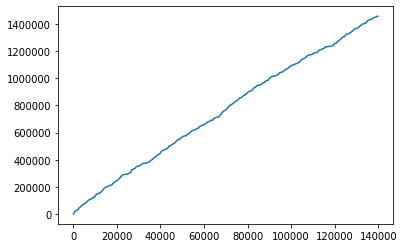

9 <Tracab.tracab_player object at 0x1c48a48510>


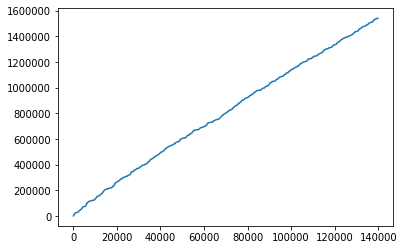

10 <Tracab.tracab_player object at 0x1c7e9e9890>


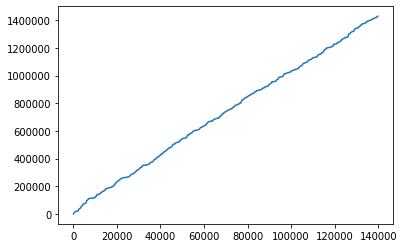

11 <Tracab.tracab_player object at 0x1cdbb28c10>


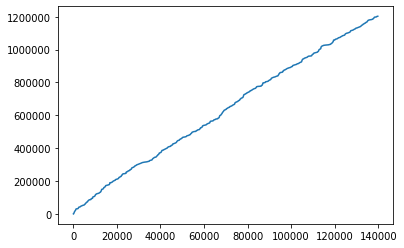

17 <Tracab.tracab_player object at 0x1ce2260f90>


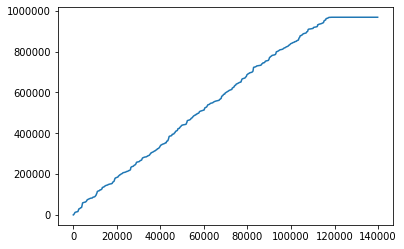

18 <Tracab.tracab_player object at 0x1ce899a350>


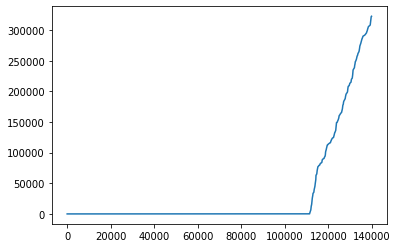

21 <Tracab.tracab_player object at 0x1cef0d26d0>


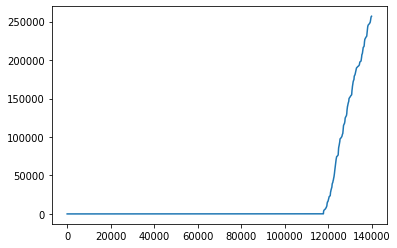

25 <Tracab.tracab_player object at 0x1cf8ec0a50>


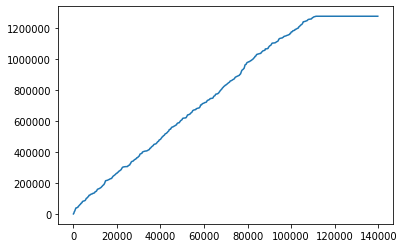

In [211]:
for i, player in team1_players.items():
    print(i, player)
    E_expend = energy_expenditure(player, wind_resistance=False)
    cumul_E = np.cumsum(E_expend)
    plt.plot(cumul_E)
    plt.show()

In [205]:
for player in position_to_player['CM']:
    

[13737, 213602, 102912, 226885]

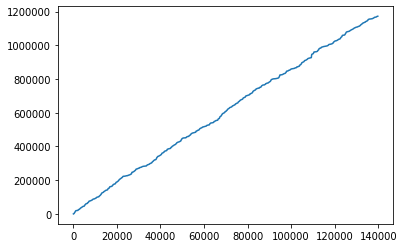

In [188]:
# wind
plt.plot(cumul_E)
plt.show()

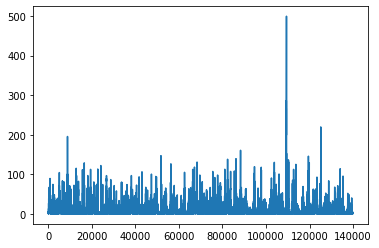

In [173]:
for team, player in all_players:
    plt.clf()
    
    vebda_toplot = helpers.get_all_values(player, 'VeBDA', start=1)
    plt.plot(vebda_toplot)
    plt.title('Plot of energy expenditure for player {} of team {}'.format(player.jersey_num, player.teamID))
    plt.savefig('./figures/VeBDA/time_series_all_{}_player_{}.jpg'.format(player.teamID, player.jersey_num))

# Energy expenditure by player position
We find the mean energy spent by player position

In [30]:
match_id = 984628
positions = {'G': 'Goalkeeper',
            'RFB': 'Right full back',
            'CD': 'Central defender',
            'CDM': 'Central defensive midfielder',
            'RM':' Right midfielder',
            'RW': 'Right wing',
            'RWB':' Right wing back',
            'AM':' Attacking midfielder',
            'FW': 'Forward'}

In [31]:
player_id_to_name = pd.read_csv(os.path.join(fpath, 'playerid_jerseynum_map.csv'))
player_id_to_name = player_id_to_name[player_id_to_name['Match ID'] == match_id]

In [37]:
player_id_to_name

,Match ID,Team,Playerid,Player name,Jersey Num,Starting Position,Starts Match
6005,984628,Home,182413,Jacob Rinne,1,GK,Start
6006,984628,Home,48601,Patrick Kristensen,2,RFB,Start
6007,984628,Home,180169,Philipp Ochs,11,LFB,Start
6008,984628,Home,80502,Jores Okore,5,CD,Start
6009,984628,Home,155453,Kasper Pedersen,32,CD,Start
6010,984628,Home,84500,Kasper Kusk,17,RM,Start
6011,984628,Home,192161,Frederik Borsting,25,LM,Start
6012,984628,Home,13737,Rasmus Wurtz,8,CM,Start
6013,984628,Home,213602,Oliver Abildgaard,7,CM,Start
6014,984628,Home,58863,Tom van Weert,9,FW,Start


In [39]:
position_to_player = player_id_to_name.groupby('Starting Position')['Playerid'].apply(list).to_dict()

In [40]:
# metric: cumulative distance
position_to_player

{'AM': [61778],
 'CD': [80502, 155453, 221234, 48715],
 'CM': [13737, 213602, 102912, 226885],
 'FW': [58863, 95194, 85050],
 'GK': [182413, 232904],
 'LFB': [180169, 135354],
 'LM': [192161, 89226],
 'RFB': [48601, 213786],
 'RM': [84500, 243724],
 'Sub': [429031,
  116697,
  165923,
  226975,
  196705,
  48597,
  229217,
  101999,
  249137,
  433055,
  227062,
  421775,
  171580,
  89443]}

### When they are attacking VS defending

# Relating to physical performance

In [120]:
player = team0_players[11]

# get accelerations
accelerations = helpers.get_all_values(player, 'a_magnitude')

In [126]:
means = helpers.get_mean_every_k(accelerations, 4000)

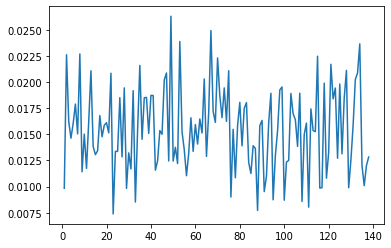

In [125]:
plt.plot(means)

In [127]:
player = team0_players[11]

# get accelerations
accelerations = helpers.get_all_values(player, 'VeBDA')

AttributeError: 'tracab_target' object has no attribute 'VeBDA'

In [ ]:
means = helpers.get_mean_every_k(accelerations, 4000)
plt.plot(means)